# Center of Gravity position measurement

This code has been developed to measure the position of the center of gravity of a mechanical part using photos without QR code. The operator will have to point different points of interest in the image to translate the pixel coordinates to world coordinates. 

#### Libraries

In [1]:
import cv2 # pip install opencv-python
import numpy as np # conda install numpy

## General code description

This code will make the translation from the pixel coordinates to the world coordinates $R_0$, illustrated in the next scheme :
<div>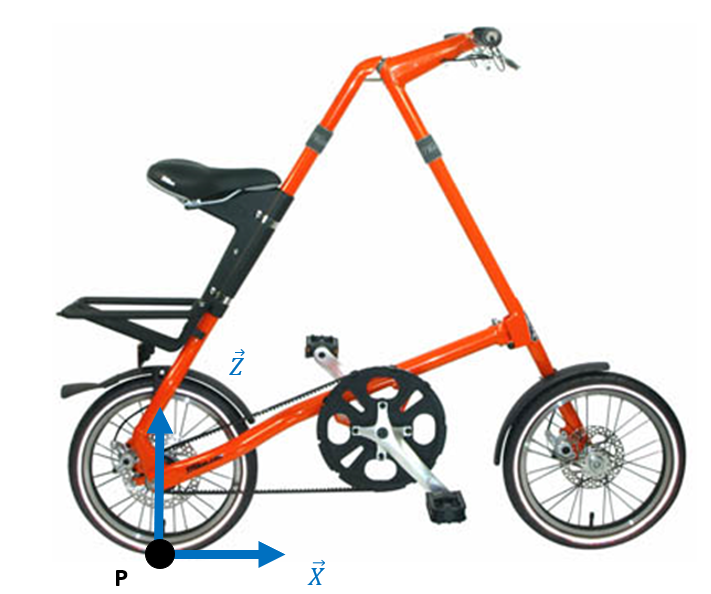</div>

This time, we do not have QR code for the image calibration, but we will use directly 4 points on the frame for which we know the real coordinates. 

## Definition of some variables specific to the part measured

Before using this code, we need to write in the code the position of the 4 points we know. 

In [2]:
# ========= Coordinates of the quadrangle corners in the world refenrece frame 
calib_pt0_real=[0,0]
calib_pt1_real=[-130,487]
calib_pt2_real=[417,487]
calib_pt3_real=[499,134]

Variables of the code. 

In [3]:
list_image = [1,2,3,4] # the list which contains all the images 
list_x = [] # the list on which we will add the x-coordinates of the clicked points.
list_y = [] # the list on which we will add the y-coordinates of the clicked points.

To modify the size of the image, you have to modify this parameter.

## Specificity for this measure
For this measure specifically, we took image with a Gopro camera on a tripod, so the camera was aligned with horizontal. So when pointing the vertical, you only have to point 1 point of the rope. 

## Loop definition during which we select interesting points on each image

For each image, you have to select 5 points, corresponding to 4 points for the calibration process and one in the rope for the line identification for the center of gravity. 

An example of the points used for the calibration is presented on the next image. /!\ Careful of the order of the points you are pointing /!\ :

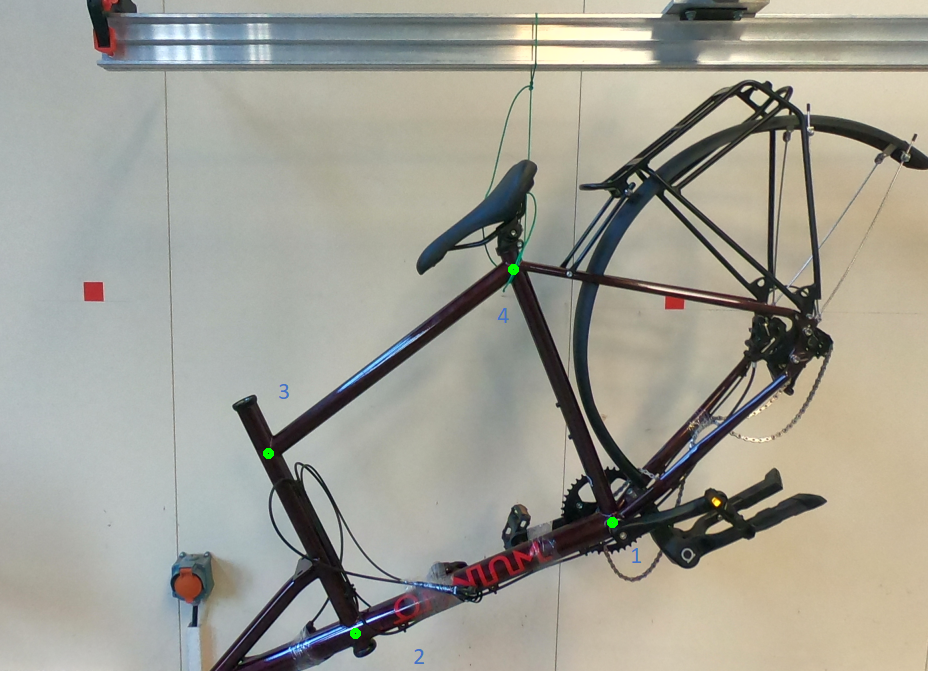

the fifth point is to used to identify the vertical rope. 

In [4]:
img_counter=0
while img_counter != len(list_image): # We go through all the images of the list
    file = "addbike\\imgomnium" + str(list_image[img_counter]) + ".JPG"
    img_counter+=1
    img=cv2.imread(file)
    calib_pt_list=[] # the clicked points will be stored in this list
    #======== Re-sizing the image for the display
    scale_percent = 40 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img_temp=img.copy() # Making a copy of this image for the calibration
    cv2.imshow("nom", img_temp)
    
    # ===== Calibration point's selection
    i=0 # point counter
    def get_point(event, x, y, flags, param): # function created for getting the pixel coordinates of the clicked point
        global calib_pt_list,i
        if event == cv2.EVENT_LBUTTONUP:
            calib_pt_list.append((x,y))
            cv2.circle(img_temp,(x,y),radius = 3,color=(0, 255, 0), thickness=3)
            cv2.imshow("nom",img_temp)
            print("Point ",i," : ",(x,y))
            i+=1
            
    print("Select the 4 points for the calibration, and one point of the rope, then press any key. ")        
    cv2.setMouseCallback("nom",get_point) # We call the pointing function
    c = cv2.waitKey(0) # Once the image is displayed, we want for any key to be pressed
    cv2.destroyAllWindows() # close the window after the key is pressed
    
    # ========= Storing the pointing coordinates
    calib_pt0_img=calib_pt_list[0]
    calib_pt1_img=calib_pt_list[1]
    calib_pt2_img=calib_pt_list[2]
    calib_pt3_img=calib_pt_list[3]

    # ======== Transformation matrix
    
    # Coordinates of the corners in the image
    image_line_pts_1 = np.float32([calib_pt0_img, calib_pt1_img, calib_pt2_img, calib_pt3_img])
    # Real coordinates of the corners 
    image_line_pts_2 = np.float32([calib_pt0_real, calib_pt3_real, calib_pt2_real, calib_pt1_real])
    
    # Transformation for the calibration and the change of reference
    H2 = cv2.getPerspectiveTransform(image_line_pts_1, image_line_pts_2)
    # resizing the image for the display
    dim = (2000,2500)
    img_calibree=cv2.warpPerspective(img_temp, H2, dim)
    img_calibree2 = img_calibree
    img_calibree_temp = img_calibree2.copy() # We keep a copy og the image for the final display
    
    x = calib_pt_list[4][0]
    x1 = x
    x2 = x
    y1 = 0
    y2 = img_calibree.shape[1]
    
    point_reel1 = H2 @ [x1,y1,1] 
    point_reel1 = point_reel1 / point_reel1[2]
    point_reel2 = H2 @ [x2,y2,1]
    point_reel2 = point_reel2 / point_reel2[2]
    
    
    # ======= Computation of the vertical line equation 
    point1 = [int(point_reel1[0]),int(point_reel1[1])]
    point2 = [int(point_reel2[0]),int(point_reel2[1])]
    
    # we compute the 2 coefficients of the line's equation
    a1 = (point1[1]-point2[1])/(point1[0]-point2[0])
    b1 = (point1[0]*point2[1]-point1[1]*point2[0])/(point1[0]-point2[0])
    x1 = 0
    y1 = int(a1*x1+b1)
    x2 = 1000
    y2 = int(a1*x2+b1)
    
    list_x.append([x1,x2])
    
    list_y.append([y1,y2])
    print(list_y)
    
# ========= Re-sizing the image
img_calibree = cv2.warpPerspective(img, H2, dim)
img_finale = img_calibree
img_finale_temp = img_finale.copy()

# ======== We plot all the lines in one image
for index_line in range(len(list_image)) :
    cv2.line(img_finale,(list_x[index_line][0],list_y[index_line][0]),(list_x[index_line][1],list_y[index_line][1]),color=(255, 0, 0), thickness=1)
list_triangle = []
# ======== Getting the 3 farthest corners of the polygon
i=0
def get_point_3(event, x, y, flags, param):
    global calib_pt_list,i
    if event == cv2.EVENT_LBUTTONUP:
        list_triangle.append((x,y))
        cv2.circle(img_finale,(x,y),radius = 2,color=(255, 0, 0), thickness=1)
        cv2.imshow("Image finale",img_finale)
        print("Point ",i," : ",(x,y))
        i+=1

print("Sélectionner les 3 sommets opposés du polygône")
cv2.imshow('Image finale',img_finale)
cv2.setMouseCallback('Image finale',get_point_3)
c = cv2.waitKey(0)
cv2.destroyAllWindows()

Select the 4 points for the calibration, and one point of the rope, then press any key. 
Point  0  :  (970, 803)
Point  1  :  (714, 913)
Point  2  :  (629, 732)
Point  3  :  (874, 551)
Point  4  :  (889, 406)
[[263, -1092]]
Select the 4 points for the calibration, and one point of the rope, then press any key. 
Point  0  :  (758, 888)
Point  1  :  (600, 630)
Point  2  :  (803, 519)
Point  3  :  (1014, 750)
Point  4  :  (800, 444)
[[263, -1092], [97, 1016]]
Select the 4 points for the calibration, and one point of the rope, then press any key. 
Point  0  :  (918, 815)
Point  1  :  (832, 598)
Point  2  :  (668, 660)
Point  3  :  (701, 909)
Point  4  :  (839, 560)
[[263, -1092], [97, 1016], [173, 64]]
Select the 4 points for the calibration, and one point of the rope, then press any key. 
Point  0  :  (744, 588)
Point  1  :  (488, 759)
Point  2  :  (621, 941)
Point  3  :  (919, 829)
Point  4  :  (737, 488)
[[263, -1092], [97, 1016], [173, 64], [-31, 2427]]
Sélectionner les 3 sommets oppos

Here we define the average point and the radius for the meaasurement's uncertainty around the center of gravity. 

In [5]:
# ========= We build the line of the triangle's points
x1 = list_triangle[0][0]
y1 = list_triangle[0][1]
x2 = list_triangle[1][0]
y2 = list_triangle[1][1]
x3 = list_triangle[2][0]
y3 = list_triangle[2][1]

# ======== Average point computation
moy_x = (x1+x2+x3)/3
moy_y = (y1+y2+y3)/3

# ======== Definition of the farthest point
norm1 = np.linalg.norm([moy_x-x1,moy_y-y1])
norm2 = np.linalg.norm([moy_x-x2,moy_y-y2])
norm3 = np.linalg.norm([moy_x-x3,moy_y-y3])

rad = np.amax((norm1,norm2,norm3))
print()
print("Center of gravity coordinates in the current frame : ", (int(moy_x),int(moy_y))," mm")
print("Circle radius : ", int(rad)," mm")
cv2.circle(img_finale,(int(moy_x),int(moy_y)),radius = int(rad),color=(0, 255, 0), thickness=2)
cv2.imshow('Image finale',img_finale)
c = cv2.waitKey(0)
cv2.destroyAllWindows()


Center of gravity coordinates in the current frame :  (78, 165)  mm
Circle radius :  13  mm


Until now, we defined the center of the crankset with the coordinates $[0,0]$. We have to select a point for which we know the coordinates in the world reference frame. We chose to select the center of the whell, which coordinates are $[0,R\_wheel]$. 

In [6]:
# ========= Compute the position of the current frame relating to the rear wheel contact point

origin = [800,500] # change the pixel coordinates of the center of the frame (for the display)

image_line_pts_3 = np.float32(np.add(image_line_pts_2,origin,dtype=float))
M = cv2.getPerspectiveTransform(image_line_pts_1,image_line_pts_3)
img_calibree=cv2.warpPerspective(img, M, dim)
moy_x += origin[0]
moy_y += origin[1]
img_finale_new = img_calibree
img_finale_new = cv2.circle(img_finale_new,(int(moy_x),int(moy_y)),radius = int(rad),color=(0, 255, 0), thickness=2)

pos_roue_AR = [0,0]
def get_point_4(event, x, y, flags, param):
    global pos_roue_AR
    if event == cv2.EVENT_LBUTTONUP:
        pos_roue_AR = [x,y]
        print(pos_roue_AR)
        pos_roue_AR[0] = pos_roue_AR[0] - origin[0]
        pos_roue_AR[1] = pos_roue_AR[1] - origin[1]
        cv2.circle(img_finale_new,(x,y),radius = 2,color=(255, 0, 0), thickness=1)
        cv2.imshow("Image finale",img_finale_new)
        print("Coordinates in the bicycle reference frame of the clicked point : ",pos_roue_AR)


print("Select the position of the rear wheel center")
cv2.imshow('Image finale',img_finale_new)
cv2.setMouseCallback('Image finale',get_point_4)
c = cv2.waitKey(0)
cv2.destroyAllWindows()

Select the position of the rear wheel center
[293, 611]
Coordinates in the bicycle reference frame of the clicked point :  [-507, 111]


## Computation of the position of the center of gravity in the world reference frame centered in the rear wheel contact point. 
to do this reference frame transforamtion, we only have to make a translation from the quadrangle position to the rear wheel contact point. 

In [7]:
Rroue_AR = 366 # mm 

# compute the translation to pass from the current reference frame to the world one
translation_repere = np.subtract([0, Rroue_AR],pos_roue_AR)
pos_CG_repere_bon = np.add(translation_repere, [moy_x-origin[0],moy_y-origin[1]])
print("Center of gravity coordinates in the world reference frame : ")
print(pos_CG_repere_bon)

Center of gravity coordinates in the world reference frame : 
[585.66666667 420.66666667]
